In [1]:
import pandas as pd
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt

from scipy.optimize import minimize

import sys
sys.path.insert(0, '../scripts/')
import utils as utl

## Predict

In [2]:
def log_reg_predict(w, X):
    return (w*X).sum(axis=1)

## Metrics

In [3]:
def confusion_matrix(y: pd.Series, y_p: pd.Series) -> np.array:
    """Calculates the confusion matrix of a classification model

    Parameters
    ----------
    y : pd.Series
        True values
    y_p : pd.Series
        Predicted values

    Returns
    -------
    np.array
        Confusion Matrix
    """
    cats = y.unique()
    n= len(cats)
    conf_matr = np.zeros((n,n))

    for i in range(len(y)):
        k = np.where(cats == y.iloc[i])[0][0]
        l = np.where(cats == y_p.iloc[i])[0][0]
        conf_matr[k][l] = conf_matr[k][l] + 1
    return conf_matr

In [4]:
def accuracy_classification(cm: np.array) -> float:
    """Correct predictions vs total number of data points

    Parameters
    ----------
    cm : np.array
        Confusion Matrix

    Returns
    -------
    float
        Accuracy
    """
    return cm.trace()/cm.sum()

def presicion_classification(cm: np.array, i: int = 0) -> float:    
    """True Positives of a given category vs total number of data points

    Parameters
    ----------
    cm : np.array
        Multiclass confusion matrix
    i : int, optional
        Index of category of interests, by default 0

    Returns
    -------
    float
        _description_
    """
    return cm[i][i]/cm[i].sum()

def recall_classification(cm: np.array, i: int = 0) -> float:    
    """True Positives of a given category vs total number of data points

    Parameters
    ----------
    cm : np.array
        Multiclass confusion matrix
    i : int, optional
        Index of category of interests, by default 0

    Returns
    -------
    float
        _description_
    """
    return cm[i][i]/cm[:,i].sum()

In [5]:
def fbeta_classification(cm: np.array, i: int = 0, beta: float = 1.0) -> float:
    p = presicion_classification(cm, i=i)
    r = recall_classification(cm, i=i)
    fb = 0
    den = ((beta**2)*p+r)
    if den !=0:
        fb = (1+beta**2)*p*r/((beta**2)*p+r)
    return fb

# Cost functions

In [6]:
def log_cost_function(w: np.array, X: np.array, y: np.array) -> float:
    """Calculates the log cost function for binary logistic regression

    Parameters
    ----------
    w : np.array
        Weights
    X : np.array
        Input values
    y : np.array
        Expected outputs

    Returns
    -------
    float
        Logistic cost function result
    """
    y_pred = log_reg_predict(w, X)
    y_pred = utl.min_max_scaling(pd.Series(y_pred))[0]
    den = 1 + np.exp(y_pred)
    den[den == 0] = 1e-4
    h = 1/den
    return - (1/len(X))*np.sum(y*np.log(h) + (1-y)*np.log(1-h))

In [7]:
def lcf_for_min(w: np.array, *args: Tuple[np.array, np.array]) -> float:
    """Calculates the log cost function for binary logistic regression in format necessary for minimization algorithm

    Parameters
    ----------
    w : np.array
        _description_

    **args: Tuple[np.array, np.array]
        np.array: Input values X
        np.array: Expected outputs y
    Returns
    -------
    float
        Logistic cost function result
    """
    X = args[0]
    y = args[1]
    return log_cost_function(w, X, y)

## Test

In [8]:
df = pd.read_csv('../data/1.raw/customerClassification.csv')#, parse_dates=['DateTime'],index_col=['DateTime'])
df.columns
X_cols = ['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size',
       'Segmentation']
X_cat_cols = ['Gender', 'Ever_Married', 'Graduated', 'Profession',
       'Spending_Score', 'Segmentation']
y_col = 'Var_1'

X = df[X_cols]
X = X.fillna(0)

for cat in X_cat_cols:
    X[cat] = X[cat].astype('category').cat.codes

for c in X.columns:
    X[c] = utl.min_max_scaling(X[c])[0]


y = df[y_col].fillna(0).astype('category').cat.codes


In [9]:
y_res = pd.DataFrame()
for cat in y.unique():
    y_np = y.copy().to_numpy()
    y_np[y_np!=cat]=-1
    y_np[y_np==cat]=1
    y_np[y_np==-1]=0
    y_res[cat] = y_np

In [10]:
X_mod = X.copy()
ones_aux = np.ones(X.shape[0])
X_mod['bias_col'] = ones_aux
cols = X_mod.columns
cols_reordered = [cols[i-1] for i,x in enumerate(cols)]
X_mod = X_mod[cols_reordered]
X_np = X_mod.to_numpy()
m = len(X_mod)


# Inicializes data
J = np.ones(len(y_res.columns))
w_df = pd.DataFrame()
for i,val in enumerate(y_res.columns):
    w_df[val] = 0.1*np.ones(X.shape[1]+1)
w = w_df.to_numpy()
y_c = y_res.to_numpy()

# Minimizes the cost function
for i,val in enumerate(y_res.columns):
    res = minimize(lcf_for_min, w[:,i], args=(X_np, y_c[:,i]))
    w[:,i] = res.x

In [11]:
# Predictions
y_pred = pd.DataFrame()
for i,val in enumerate(y_res.columns):
    y_pred[val] = log_reg_predict(w[:,i], X_np)
    y_pred[val] = utl.min_max_scaling(y_pred[val])[0]

orig_cols = y_pred.columns
y_pred['res'] = y_pred.apply(lambda x: np.argmax(x[orig_cols].to_numpy()) ,axis =1)
y_p = y_pred['res']

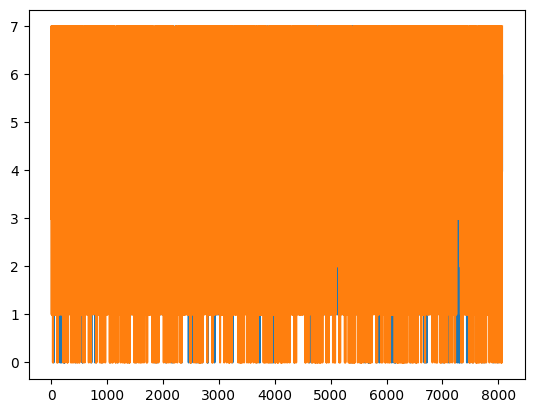

In [12]:
plt.plot(y)
plt.plot(y_pred['res'])
# for c in y_pred.columns:
#     plt.plot(y_pred[c])
plt.show()

In [13]:
cm = confusion_matrix(y, y_p)
acc = accuracy_classification(cm)
pres = presicion_classification(cm)
rec = recall_classification(cm)
f1 = fbeta_classification(cm)

In [14]:
acc, pres, rec, f1

(0.0835399107585523,
 0.16161616161616163,
 0.09887640449438202,
 0.1226908330428721)

## Comparison with scikit learn

In [15]:
from sklearn.linear_model import LogisticRegression

In [16]:
clf = LogisticRegression(random_state=0).fit(X,y)
y_pred_skl_np = clf.predict(X)
y_pred_skl = pd.Series(y_pred_skl_np)

c:\Users\an2fe\anaconda3\envs\mlmodels\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
cm_skl = confusion_matrix(y, y_pred_skl)
acc_skl = accuracy_classification(cm_skl)
pres_skl = presicion_classification(cm_skl)
rec_skl = recall_classification(cm_skl)
f1_skl = fbeta_classification(cm_skl)

acc_skl, pres_skl, rec_skl, f1_skl

(0.6512146752602875,
 0.050505050505050504,
 0.3873239436619718,
 0.0893582453290008)